In [1]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import tensorflow as tf
from tensorflow.keras import layers, models


## Download data

Download the dataset from [here](https://www.kaggle.com/datasets/hassiahk/stanford-cars-dataset-full), and extract it to `./data/car_ims/`.

In [3]:
# Load data

data_path = Path('./data')
margin = 16
im_path = data_path / 'images'
im_path.mkdir(exist_ok=True)

mat = sio.loadmat(data_path / 'cars_annos.mat')


# Class names
class_names = [
    name[0].replace('/', '_')
    for name in mat['class_names'][0]
]
num_classes = len(class_names)
print(f"{num_classes} class names loaded")

196 class names loaded


In [ ]:
# Image files
# You should only run this once
image_count = 0
for ([fp], [[x1]], [[y1]], [[x2]], [[y2]], [[class_id]], _) in mat['annotations'][0]:
    fp = Path(fp)
    src_img = cv2.imread(str(data_path / fp))
    h, w = src_img.shape[:2]
    class_name = class_names[class_id - 1]
    # Crop image
    x1 = max(0, x1 - margin)
    y1 = max(0, y1 - margin)
    x2 = min(x2 + margin, w)
    y2 = min(y2 + margin, h)
    dst_img = src_img[y1:y2, x1:x2]
    # Save image
    image_dir = im_path / class_name
    image_dir.mkdir(exist_ok=True)
    cv2.imwrite(str(image_dir / fp.name), dst_img)
    image_count += 1
    if image_count % 1000 == 0:
        print(f"progress: {image_count}")

print(f"Total {image_count} images loaded")

In [4]:
# Create datasets
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    str(im_path),
    seed=42,
    validation_split=0.1,
    subset='both',
    label_mode='categorical',
    image_size=(128,128)
)


Found 16185 files belonging to 196 classes.
Using 14567 files for training.
Using 1618 files for validation.


(128, 128, 3)


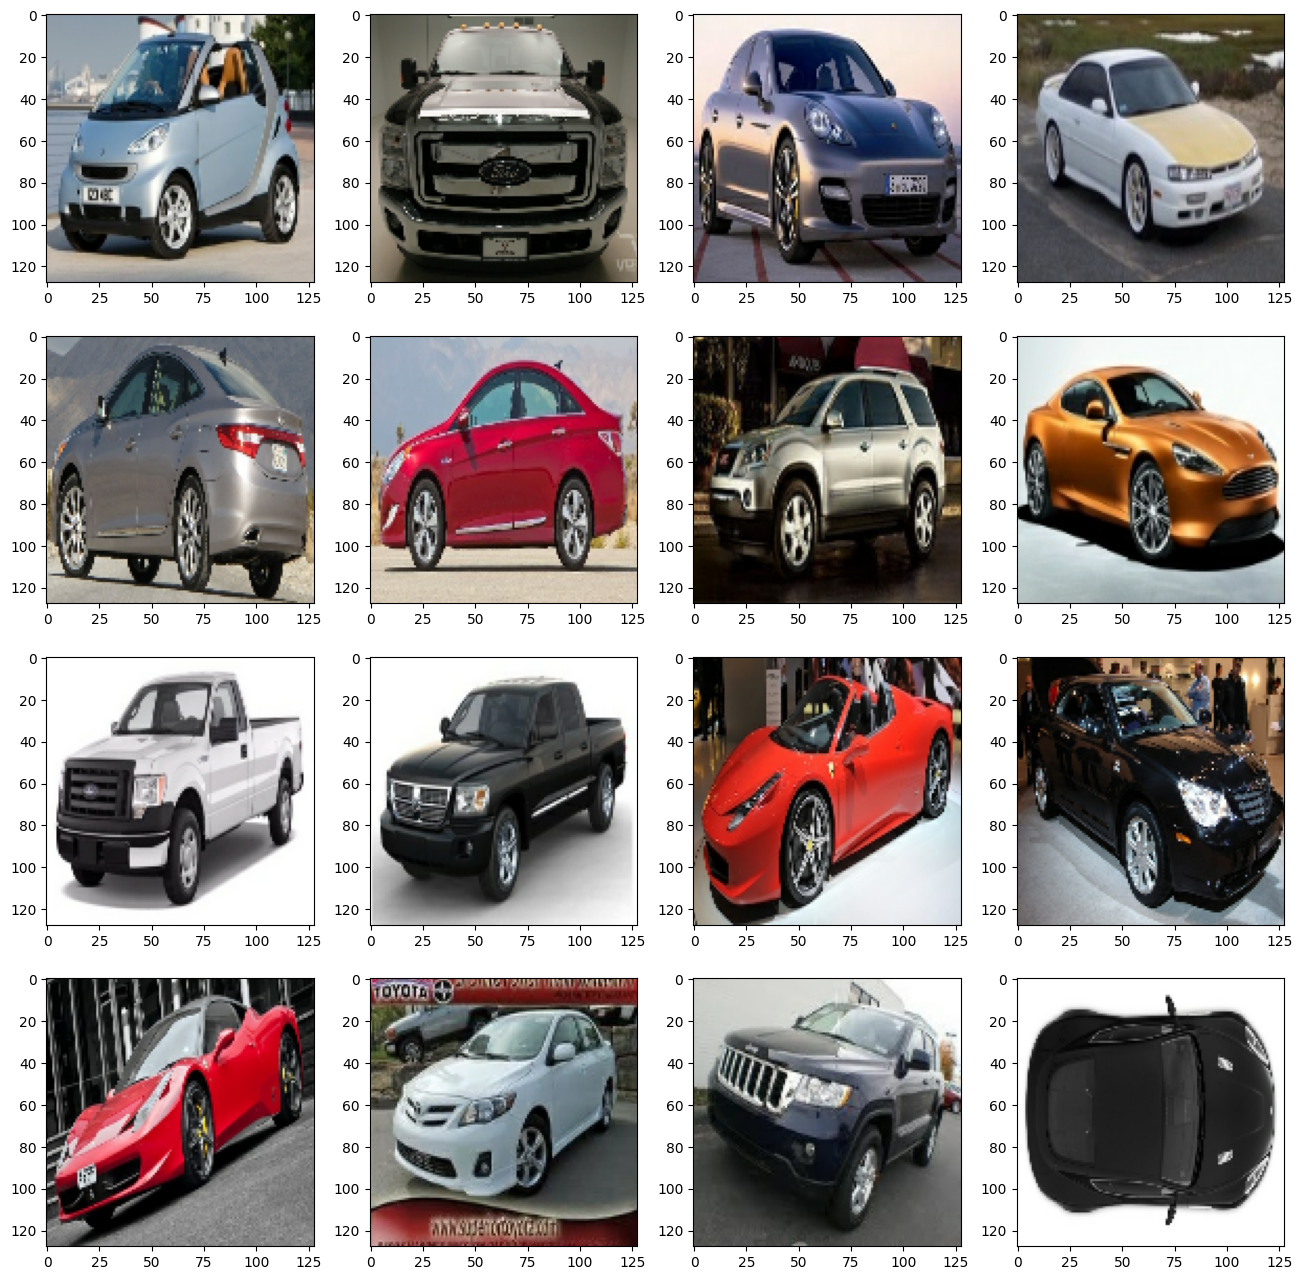

In [5]:
# Visualize the dataset
batch = next(train_ds.as_numpy_iterator())

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(batch[0][i].astype(int))

input_shape = batch[0][0].shape
print(input_shape)

In [10]:
model = models.Sequential([
    layers.Conv2D(16, 3, activation='relu',
                  input_shape=input_shape),
    layers.MaxPool2D(strides=2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPool2D(strides=2),
    layers.Conv2D(32, 5, activation='relu'),
    layers.MaxPool2D(strides=2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPool2D(strides=2),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

model.summary()

In [11]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

cp_cb = tf.keras.callbacks.ModelCheckpoint(
    str(data_path / 'checkpoints'),
)

history = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=[cp_cb]
)
